# Deep Q Networks
前面我们介绍了强化学习中的 q-learning，我们知道对于 q-learning，我们需要使用一个 Q 表来存储我们的状态和动作，每次我们使用 agent 不断探索环境来更新 Q 表，最后我们能够根据 Q 表中的状态和动作来选择最优的策略。但是使用这种方式有一个很大的局限性，如果在现实生活中，情况就会变得非常的复杂，我们可能有成千上万个 state，甚至是无穷无尽有可能是无穷无尽的 state，对于这种情况，我们不可能将所有的 state 都用 Q 表来存储，那么我们该如何解决这个问题呢？

一个非常简单的办法就是使用深度学习来解决这个问题，所以出现了一种新的网络，叫做 Deep Q Networks，将 Q learning 和 神经网络结合在了一起，对于每一个 state，我们都可以使用神经网络来计算对应动作的值，就不在需要建立一张表格，而且网络更新比表格更新更有效率，获取结果也更加高效。

![](https://ws4.sinaimg.cn/large/006tKfTcgy1fni66at6jbj30xo0g1jut.jpg)

下面我们使用 open ai gym 环境中的 CartPole 来尝试实现一个简单的 DQN。

In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import numpy as np
import gym

定义一些超参数

In [2]:
batch_size = 32
lr = 0.01
epsilon = 0.9
gamma = 0.9
target_replace_iter = 100
memory_capacity = 2000
env = gym.make('CartPole-v0')
env = env.unwrapped
n_actions = env.action_space.n
n_states = env.observation_space.shape[0]

In [3]:
print('number of actions are: {}'.format(n_actions))
print('number of states are: {}'.format(n_states))

number of actions are: 2
number of states are: 4


这里使用 gym 自带的环境，关于 CartPole 的一些参数，我们同样可以像上一节课 MountainCar 一样找到，[地址]( https://github.com/openai/gym/wiki/CartPole-v0) 在这里，通过这里可以看到，这个环境的观测的 4 个值分别是板的位置，板的速度，杆的角度以及杆顶端的速度，我们能够采取的动作就是 2 个，分别是向左移动杆和向右移动杆。

本质上，我们其实可以不用关心状态到底是什么，这些状态都可以作为神经网络的输入，输出就是每个动作的 value，可以让神经网络自己学会建立一个类似 Q 表的东西。

In [4]:
class q_net(nn.Module):
    def __init__(self, hidden=50):
        super(q_net, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(n_states, hidden),
            nn.ReLU(True),
            nn.Linear(hidden, n_actions)
        )
        
        nn.init.normal(self.fc[0].weight, std=0.1) # 使用标准差是 0.1 的正态分布初始化
        nn.init.normal(self.fc[2].weight, std=0.1) # 使用标准差是 0.1 的正态分布初始化
        
    def forward(self, x):
        actions_value = self.fc(x)
        return actions_value

接下来我们定义一个 DQN 的过程作为一个类，在这个类中，我们会定义 dqn 的学习过程，dqn 的更新过程和之前讲个 q learning 的过程是很相同的

![](https://ws1.sinaimg.cn/large/006tNc79ly1fnhl68e9spj30ek0biwfw.jpg)

上图中有两个网络，第一个网络叫做 action-value function Q，还有一个网络叫做 target action-value $\hat{Q}$，第一个网络可以称为 eval net，第二个网络叫做 target net，eval net 每一步都更新参数，而 target net 每过 C 步才更新一次，更新地方式是直接将 eval net 的参数复制到 target net 上，为什么要学习两个网络而不学习一个网络呢？因为 DQN 希望每次更新能够有一定的时间去探索周围的环境而得到更多的信息再来更新，在游戏中的过程是一个时间序列，所以得到的信息是有着时间依赖关系，每次都直接使用序列信息进行更新并不能得到好的结果，所以我们就采用滞后更新的方式，每隔 C 步才真正更新一次参数。

DQN 的学习过程也非常简单，我们使用 eval net 作为估计动作的 value，使用 target net 得到动作实际的 value，我们希望估计的 value 能够等于实际的 value，所以可以使用 mse 来作为 loss 函数就可以了。

下面我们来实现整个过程

In [12]:
class DQN(object):
    def __init__(self):
        self.eval_net, self.target_net = q_net(), q_net()

        self.learn_step_counter = 0
        self.memory_counter = 0
        self.memory = np.zeros((memory_capacity, n_states * 2 + 2)) # 当前的状态和动作，之后的状态和动作
        self.optimizer = torch.optim.Adam(self.eval_net.parameters(), lr=lr)
        self.criterion = nn.MSELoss()
 
    def choose_action(self, s):
        '''
        根据输入的状态得到所有可行动作的价值估计
        '''
        s = Variable(torch.unsqueeze(torch.FloatTensor(s), 0))
        # input only one sample
        if np.random.uniform() < epsilon:  # greedy 贪婪算法
            actions_value = self.eval_net(s)
            action = torch.max(actions_value, 1)[1].data[0]
        else:  # random 随机选择
            action = np.random.randint(0, n_actions)
        return action

    def store_transition(self, s, a, r, s_):
        transition = np.hstack((s, [a, r], s_))
        # 用新的记忆替换旧的记忆
        index = self.memory_counter % memory_capacity
        self.memory[index, :] = transition
        self.memory_counter += 1

    def learn(self):
        # target net 的参数更新
        if self.learn_step_counter % target_replace_iter == 0:
            self.target_net.load_state_dict(self.eval_net.state_dict())
        self.learn_step_counter += 1

        # 取样记忆中的经历
        sample_index = np.random.choice(memory_capacity, batch_size)
        b_memory = self.memory[sample_index, :]
        b_s = Variable(torch.FloatTensor(b_memory[:, :n_states]))
        b_a = Variable(
            torch.LongTensor(b_memory[:, n_states:n_states + 1].astype(int)))
        b_r = Variable(
            torch.FloatTensor(b_memory[:, n_states + 1:n_states + 2]))
        b_s_ = Variable(torch.FloatTensor(b_memory[:, -n_states:]))

        # q_eval net 评估状态下动作的 value
        q_eval = self.eval_net(b_s).gather(1, b_a)  # shape (batch, 1) 选择对应 action 的动作
        q_next = self.target_net(
            b_s_).detach()  # detach from graph, don't backpropagate
        q_target = b_r + gamma * q_next.max(1)[0].view(batch_size, 1)  # shape (batch, 1)
        loss = self.criterion(q_eval, q_target) # mse 作为 loss 函数
        # 更新网络
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

In [13]:
dqn_trainer = DQN()

In [14]:
print('collecting experience ... ')
all_reward = []
for i_episode in range(300):
    s = env.reset()
    reward = 0
    while True:
#         env.render()
        a = dqn_trainer.choose_action(s)

        # 环境采取动作得到结果
        s_, r, done, info = env.step(a)

        # 修改奖励以便更快收敛
        x, x_dot, theta, theta_dot = s_
        r1 = (env.x_threshold - abs(x)) / env.x_threshold - 0.8
        r2 = (env.theta_threshold_radians - abs(theta)) / env.theta_threshold_radians - 0.5
        r = r1 + r2

        dqn_trainer.store_transition(s, a, r, s_)

        reward += r
        if dqn_trainer.memory_counter > memory_capacity: # 记忆收集够开始学习
            dqn_trainer.learn()
            if done:
                print('Ep: {} | reward: {:.3f}'.format(i_episode, round(reward, 3)))
                all_reward.append(reward)
                break

        if done:
            break
        s = s_

collecting experience ... 
Ep: 199 | reward: 1.720
Ep: 200 | reward: 4.116
Ep: 201 | reward: 2.598
Ep: 202 | reward: 7.261
Ep: 203 | reward: 1.570
Ep: 204 | reward: 1.191
Ep: 205 | reward: 2.557
Ep: 206 | reward: 2.822
Ep: 207 | reward: 1.788
Ep: 208 | reward: 3.345
Ep: 209 | reward: 2.787
Ep: 210 | reward: 2.718
Ep: 211 | reward: 21.747
Ep: 212 | reward: 2.514
Ep: 213 | reward: 1.504
Ep: 214 | reward: 5.059
Ep: 215 | reward: -1.003
Ep: 216 | reward: 5.880
Ep: 217 | reward: 25.360
Ep: 218 | reward: 19.871
Ep: 219 | reward: 6.934
Ep: 220 | reward: 35.473
Ep: 221 | reward: 46.048
Ep: 222 | reward: 34.585
Ep: 223 | reward: 103.504
Ep: 224 | reward: 92.848
Ep: 225 | reward: 61.636
Ep: 226 | reward: 68.378
Ep: 227 | reward: 150.926
Ep: 228 | reward: 358.854
Ep: 229 | reward: -303.586
Ep: 230 | reward: 44.629
Ep: 231 | reward: 271.936
Ep: 232 | reward: 93.458
Ep: 233 | reward: 203.914
Ep: 234 | reward: 126.819
Ep: 235 | reward: 492.525
Ep: 236 | reward: 865.907
Ep: 237 | reward: 457.963
Ep: 

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

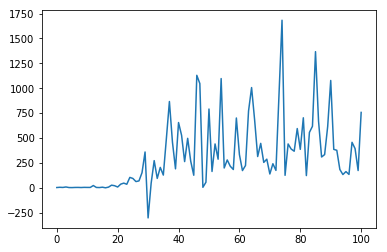

In [16]:
plt.plot(all_reward)

我们画出 reward 的曲线，可以发现奖励在不断变多，说明我们的 agent 学得越来越好，同时我们也可以实实在在地看到 agent 玩得怎么样，gym 提供了可视化的过程，但是 notebook 里面没有办法显示，我们可以使用运行 `dqn.py` 来看到 agent 玩的可视化视频。

另外，我们这里只使用了简单的多层神经网络来作为 dqn 的网络结构，网络的输入是杆的位置信息和角度等等，我们当然可以使用更加一般的输入，比如说每个状态都是一个图片的输入，那么这种方式更具有一般性，实现上几乎是一模一样，只需要改一改网络结构，同时 gym 中也可以得到每个屏幕的输出，具体可以看看 pytorch 的[官方例子](http://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html#)。